In [1]:
import os
import pandas as pd

# Hardcoded directories for 'yes' and 'no'
yes_dir = '/Users/yannietchi/Desktop/comp-562-final-project/MRI data/yes'
no_dir = '/Users/yannietchi/Desktop/comp-562-final-project/MRI data/no'


Sample images from 'yes' (Tumor) dataset:


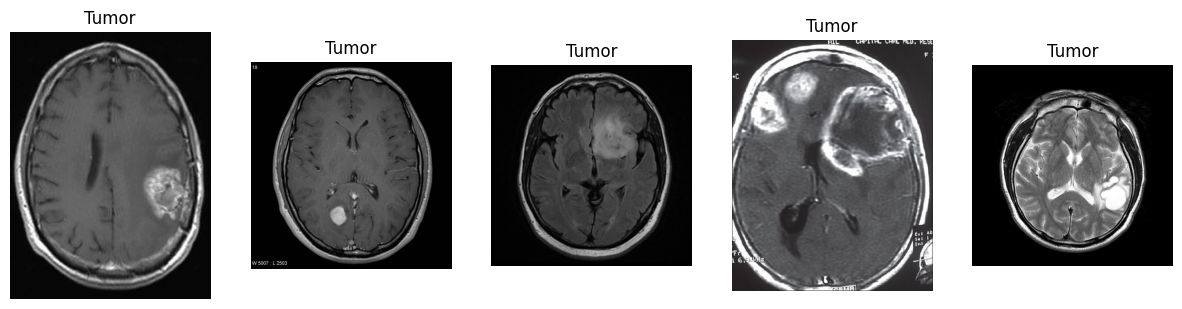

Sample images from 'no' (No Tumor) dataset:


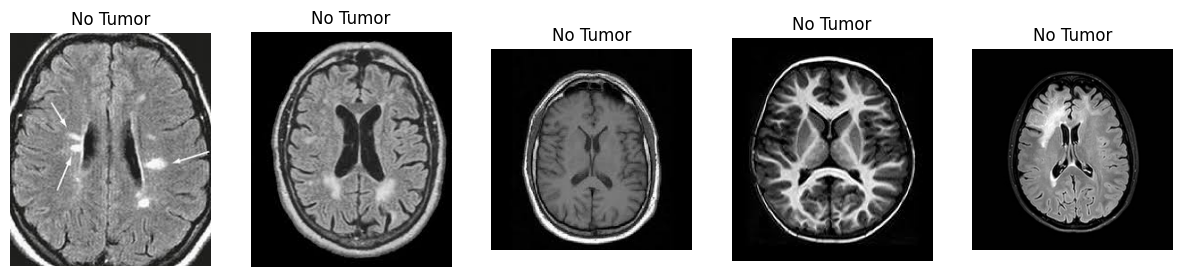

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Function to display sample images from a folder
def display_images(folder, label, n=5):
    # Get all image files from the folder
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
    # Select up to `n` images to display
    image_files = image_files[:n]
    
    # Create a figure
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_files):
        img = Image.open(img_path)  # Open the image
        plt.subplot(1, n, i + 1)    # Add a subplot
        plt.imshow(img, cmap='gray')  # Display the image
        plt.title(label)  # Title as the label
        plt.axis('off')   # Turn off axes
    plt.show()


# Display sample images from 'yes' and 'no'
print("Sample images from 'yes' (Tumor) dataset:")
display_images(yes_dir, label="Tumor")

print("Sample images from 'no' (No Tumor) dataset:")
display_images(no_dir, label="No Tumor")


In [3]:
image_paths = []
labels = []

# Process 'yes' folder
for filename in os.listdir(yes_dir):
    file_path = os.path.join(yes_dir, filename)
    if os.path.isfile(file_path):  # Ensure it's a file
        image_paths.append(file_path)
        labels.append(1)  # Label for tumor

# Process 'no' folder
for filename in os.listdir(no_dir):
    file_path = os.path.join(no_dir, filename)
    if os.path.isfile(file_path):  # Ensure it's a file
        image_paths.append(file_path)
        labels.append(0)  # Label for no tumor

# Create the dataframe
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Display the first few rows

data


,image_path,label
0,/Users/yannietchi/Desktop/comp-562-final-proje...,1
1,/Users/yannietchi/Desktop/comp-562-final-proje...,1
2,/Users/yannietchi/Desktop/comp-562-final-proje...,1
3,/Users/yannietchi/Desktop/comp-562-final-proje...,1
4,/Users/yannietchi/Desktop/comp-562-final-proje...,1
...,...,...
248,/Users/yannietchi/Desktop/comp-562-final-proje...,0
249,/Users/yannietchi/Desktop/comp-562-final-proje...,0
250,/Users/yannietchi/Desktop/comp-562-final-proje...,0
251,/Users/yannietchi/Desktop/comp-562-final-proje...,0


<h2> Data Augmentation</h2>

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

# Define data augmentation for grayscale images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to load and augment images
def augment_images(folder, label, augmentor, num_augments=3):
    data = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        if os.path.isfile(img_path):
            # Load and preprocess image
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img).reshape((1, img.size[1], img.size[0], 1))  # Reshape for augmentation
            
            # Append original image to data
            data.append({'image': img.squeeze(), 'label': label})

            # Generate augmented images
            aug_iter = augmentor.flow(img, batch_size=1)
            for _ in range(num_augments):
                aug_img = next(aug_iter)[0].squeeze()
                data.append({'image': aug_img, 'label': label})
    return data



# Augment images in both folders
yes_data = augment_images(yes_dir, 1, datagen, num_augments=3)  # Tumor label is 1
no_data = augment_images(no_dir, 0, datagen, num_augments=3)    # No-tumor label is 0

# Combine data into a DataFrame
data_augmented = yes_data + no_data
df_augmented = pd.DataFrame(data_augmented)

# Example: Display first few rows of the DataFrame
df_augmented


,image,label
0,"[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",1
1,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
2,"[[6.0, 6.0, 6.0, 6.0, 6.522367, 6.996174, 6.95...",1
3,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
4,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1
...,...,...
1007,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1008,"[[28, 29, 0, 2, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1009,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1010,"[[2.0542784, 2.2588012, 2.463324, 2.6678467, 2...",0


In [5]:
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from PIL import Image
import os
import random

# Set the target size for images
target_size = (64, 64)

# Augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a DataFrame to store image and label
augmented_images = []

# Loop through the original 'yes' and 'no' folders and augment images
def augment_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Open the image
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img)
            
            # Standardize shape to target size (e.g., 64x64)
            img_resized = resize(np.expand_dims(img, axis=-1), target_size).numpy()

            # Perform augmentation
            img_reshaped = img_resized.reshape((1,) + img_resized.shape)  # Reshape for augmentation
            it = datagen.flow(img_reshaped, batch_size=1)

            # Store augmented images and their labels
            for _ in range(5):  # Augment and store 5 versions per image
                augmented_img = next(it)[0].astype(np.uint8)  # Get the augmented image
                augmented_images.append([augmented_img, label])


# Augment images from 'yes' and 'no' folders
augment_images_from_folder(yes_dir, 1)  # Tumor label = 1
augment_images_from_folder(no_dir, 0)  # No tumor label = 0

# Convert to DataFrame
df_augmented = pd.DataFrame(augmented_images, columns=['image', 'label'])

# Show a sample from the dataframe (e.g., first 3 images)
df_augmented.head(3)




,image,label
0,"[[[1], [1], [1], [58], [89], [63], [32], [47],...",1
1,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...",1
2,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...",1


<h2> Baseline Model<h2>

Epoch 1/20
22/22 [==============================] - 2s 72ms/step - loss: 1.1409 - accuracy: 0.4884 - val_loss: 1.0091 - val_accuracy: 0.5349
Epoch 2/20
22/22 [==============================] - 2s 70ms/step - loss: 1.0387 - accuracy: 0.5058 - val_loss: 0.8044 - val_accuracy: 0.5349
Epoch 3/20
22/22 [==============================] - 2s 97ms/step - loss: 0.9826 - accuracy: 0.4986 - val_loss: 0.7341 - val_accuracy: 0.5233
Epoch 4/20
22/22 [==============================] - 4s 188ms/step - loss: 0.9153 - accuracy: 0.4942 - val_loss: 0.7016 - val_accuracy: 0.5233
Epoch 5/20
22/22 [==============================] - 3s 152ms/step - loss: 0.8671 - accuracy: 0.5361 - val_loss: 0.6852 - val_accuracy: 0.5581
Epoch 6/20
22/22 [==============================] - 3s 143ms/step - loss: 0.8361 - accuracy: 0.5318 - val_loss: 0.6767 - val_accuracy: 0.5698
Epoch 7/20
22/22 [==============================] - 3s 152ms/step - loss: 0.7946 - accuracy: 0.5535 - val_loss: 0.6721 - val_accuracy: 0.6279
Epoch 8/2

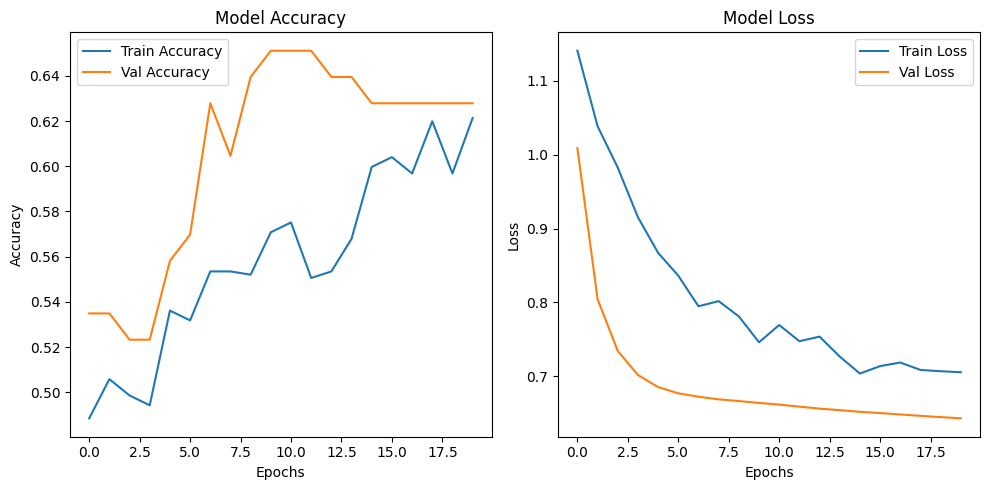

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Assuming df_augmented is already created as shown in the previous steps
X = np.array([np.expand_dims(img, axis=-1) for img in df_augmented['image']])  # Shape: (n_samples, 64, 64, 1)
y = np.array(df_augmented['label'])  # Labels: 0 or 1

# First split the data into training and temporary (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define CNN model architecture

def baseline_cnn_model(input_shape=(64, 64, 1)):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Global average pooling to reduce dimensions and avoid overfitting
    model.add(GlobalAveragePooling2D())
    
    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # For binary classification (tumor vs non-tumor)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


# Create CNN model
baseline_model = baseline_cnn_model()

# Train the model
history = baseline_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

# Plot the learning curves
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


<h2> Test<h3>

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_test, y_test, threshold=0.5):
    
    # Predict probabilities or labels
    y_pred_prob = model.predict(X_test)
    
    # For binary classification, convert probabilities to labels
    if y_pred_prob.shape[1] == 1:  # Binary classification
        y_pred = (y_pred_prob > threshold).astype(int)
    else:  # For multi-class classification
        y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a 1x2 subplot layout (side-by-side)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Tumor', 'Tumor'], yticklabels=['Non-Tumor', 'Tumor'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # ROC Curve
    if y_pred_prob.shape[1] == 1:  # Binary classification
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        axes[1].plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='lower right')
    else:
        axes[1].text(0.5, 0.5, "ROC curve is only applicable for binary classification.", horizontalalignment='center', verticalalignment='center', fontsize=12)
        axes[1].axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()



3/3 [==============================] - 0s 18ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.74      0.67        43
           1       0.68      0.52      0.59        44

    accuracy                           0.63        87
   macro avg       0.64      0.63      0.63        87
weighted avg       0.64      0.63      0.63        87



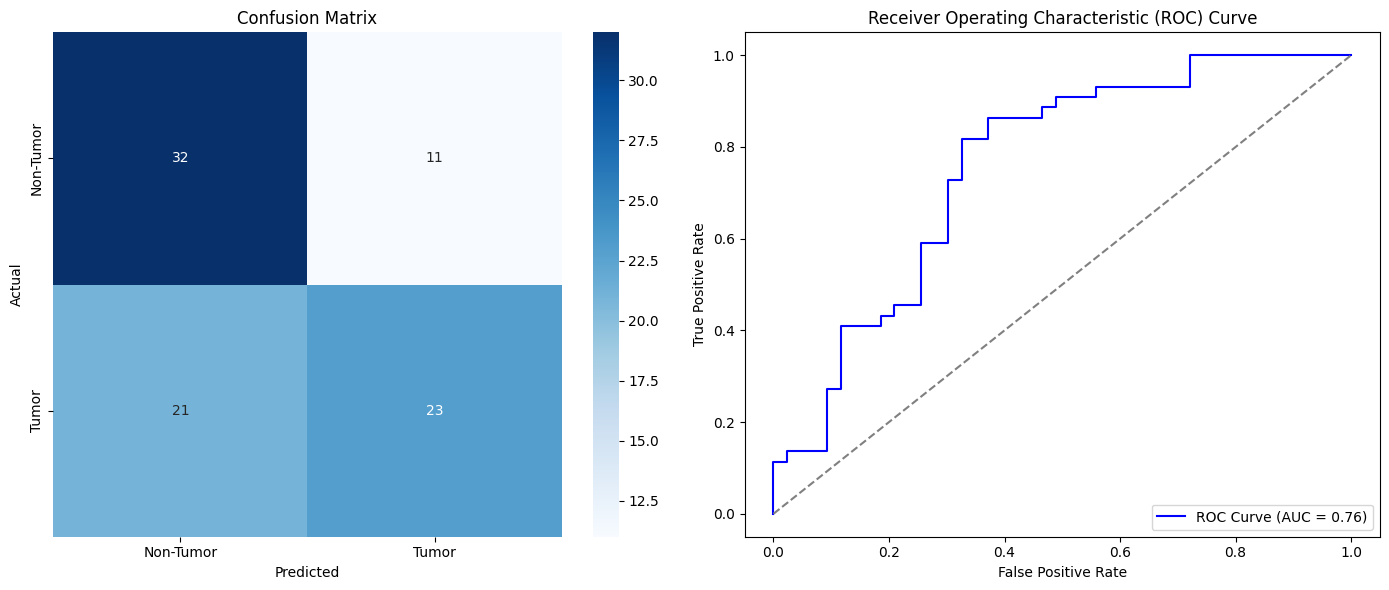

In [30]:
evaluate_model(baseline_model,X_test,y_test)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, X, y, num_samples=5):

    # Remove extra singleton dimensions (if any)
    X = np.squeeze(X)

    # Generate predictions
    y_pred = model.predict(X[:num_samples])

    # Plot the images with true and predicted labels
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # Ensure the image is in the correct format for displaying (height, width, channels)
        img = X[i]
        
        # Check if it's a grayscale or RGB image and process accordingly
        if img.ndim == 2:  # Grayscale image
            plt.imshow(img, cmap='gray')
        else:  # RGB image
            plt.imshow(img)
        
        plt.title(f"True: {'Tumor' if y[i] == 1 else 'Non-Tumor'}\nPred: {'Tumor' if y_pred[i] > 0.5 else 'Non-Tumor'}")
        plt.axis('off')
    
    plt.show()

# Example usage:
show_predictions(baseline_model, X_test, y_test, num_samples=5)

X_test.shape

2024-11-23 17:10:10.305244: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:761 : INVALID_ARGUMENT: convolution input must be 4-dimensional: [5,64,64]


InvalidArgumentError: Graph execution error:

Detected at node sequential_3/conv2d_9/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/yannietchi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/yn/ftl55p110bl7f4vqh175t6mh0000gn/T/ipykernel_48667/2247945703.py", line 32, in <module>

  File "/var/folders/yn/ftl55p110bl7f4vqh175t6mh0000gn/T/ipykernel_48667/2247945703.py", line 10, in show_predictions

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend.py", line 5395, in relu

convolution input must be 4-dimensional: [5,64,64]
	 [[{{node sequential_3/conv2d_9/Relu}}]] [Op:__inference_predict_function_184234]

<h2> Hyperparameter tuning<h2>

Reloading Tuner from tuner_dir/cnn_hyperparam_tuning/tuner0.json


Best Hyperparameters: {'filters_1': 64, 'dropout_1': 0.2, 'filters_2': 64, 'dropout_2': 0.2, 'filters_3': 384, 'dropout_3': 0.4, 'dense_units': 256, 'dropout_4': 0.3, 'learning_rate': 0.0009969653267339197}
Epoch 1/20
22/22 [==============================] - 5s 168ms/step - loss: 0.1145 - accuracy: 0.9682 - val_loss: 0.4390 - val_accuracy: 0.8488
Epoch 2/20
22/22 [==============================] - 7s 313ms/step - loss: 0.1113 - accuracy: 0.9639 - val_loss: 0.2006 - val_accuracy: 0.9419
Epoch 3/20
22/22 [==============================] - 7s 299ms/step - loss: 0.1138 - accuracy: 0.9552 - val_loss: 0.9615 - val_accuracy: 0.7093
Epoch 4/20
22/22 [==============================] - 6s 283ms/step - loss: 0.1130 - accuracy: 0.9509 - val_loss: 0.4451 - val_accuracy: 0.8605
Epoch 5/20
22/22 [==============================] - 6s 283ms/step - loss: 0.1232 - accuracy: 0.9538 - val_loss: 0.2710 - val_accuracy: 0.9070
Epoch 6/20
22/22 [==============================] - 6s 277ms/step - loss: 0.1005 - 

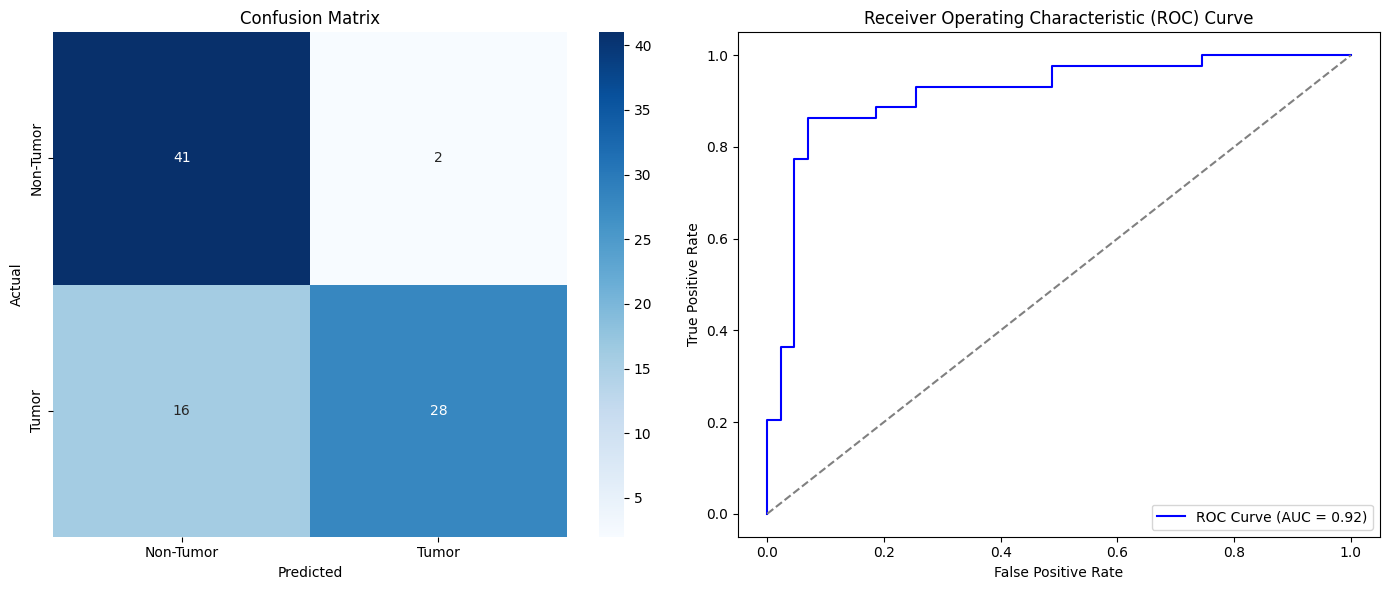

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Define the CNN model with hyperparameters
def baseline_cnn_model(hp, input_shape=(64, 64, 1)):
    model = Sequential()
    
    # First convolutional block with hyperparameters for filters and dropout rate
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), 
                     (3, 3), 
                     activation='relu', 
                     padding='same', 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Second convolutional block
    model.add(Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64), 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Third convolutional block
    model.add(Conv2D(hp.Int('filters_3', min_value=128, max_value=512, step=128), 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Global average pooling to reduce dimensions and avoid overfitting
    model.add(GlobalAveragePooling2D())
    
    # Fully connected layer with hyperparameter for units and dropout rate
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # For binary classification (tumor vs non-tumor)
    
    # Compile the model with hyperparameter tuning for learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Setup Keras Tuner for hyperparameter search
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    tuner = kt.RandomSearch(
        baseline_cnn_model,
        objective='val_accuracy',
        max_trials=10,  # Number of different hyperparameter combinations to try
        executions_per_trial=1,
        directory='tuner_dir',
        project_name='cnn_hyperparam_tuning'
    )
    
    # Perform hyperparameter search
    tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
    
    # Get the best model and hyperparameters
    best_model = tuner.get_best_models()[0]
    best_hyperparameters = tuner.get_best_hyperparameters()[0]
    
    print(f"Best Hyperparameters: {best_hyperparameters.values}")
    
    return best_model

# Train and evaluate the best model
def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test):
    # Run hyperparameter tuning
    best_model = hyperparameter_tuning(X_train, y_train, X_val, y_val)
    
    # Evaluate the best model on test data
    history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
    
    # Evaluate on test set
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Use your previous evaluation function to plot confusion matrix and ROC curve

    
    evaluate_model(best_model, X_test, y_test)
    
    # Return the best model and training history
    return best_model, history

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already prepared
best_model, history = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test)


<h2>Pre trained model Resnet 50<h2>

Epoch 1/20
22/22 [==============================] - 8s 284ms/step - loss: 0.7387 - accuracy: 0.5376 - val_loss: 0.6822 - val_accuracy: 0.6279
Epoch 2/20
22/22 [==============================] - 7s 303ms/step - loss: 0.7267 - accuracy: 0.5072 - val_loss: 0.6772 - val_accuracy: 0.6047
Epoch 3/20
22/22 [==============================] - 6s 269ms/step - loss: 0.7145 - accuracy: 0.5564 - val_loss: 0.6682 - val_accuracy: 0.6047
Epoch 4/20
22/22 [==============================] - 6s 258ms/step - loss: 0.7231 - accuracy: 0.5246 - val_loss: 0.6626 - val_accuracy: 0.6163
Epoch 5/20
22/22 [==============================] - 6s 273ms/step - loss: 0.7117 - accuracy: 0.5520 - val_loss: 0.6555 - val_accuracy: 0.6047
Epoch 6/20
22/22 [==============================] - 6s 265ms/step - loss: 0.6858 - accuracy: 0.5621 - val_loss: 0.6526 - val_accuracy: 0.6047
Epoch 7/20
22/22 [==============================] - 6s 273ms/step - loss: 0.6936 - accuracy: 0.5462 - val_loss: 0.6498 - val_accuracy: 0.6047
Epoch 

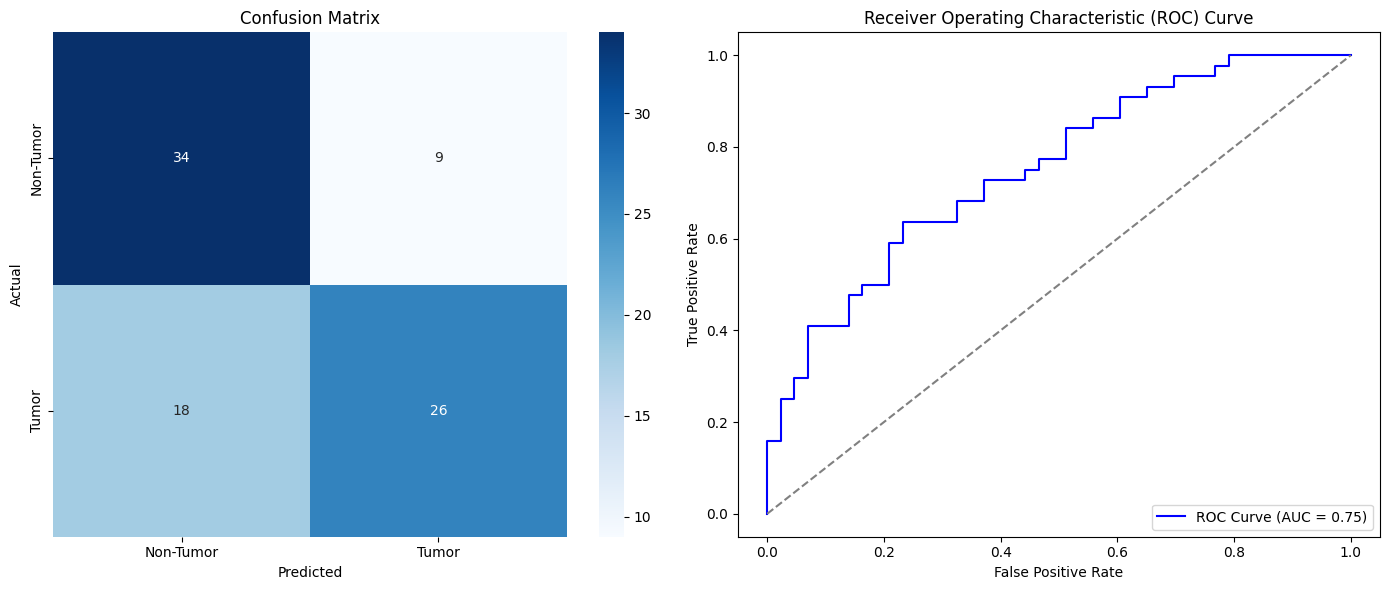

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adjust input shape to match ResNet requirements
input_shape = (64, 64, 3)  # ResNet expects 3 channels

# Expand channel for grayscale
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1)  # (692, 64, 64, 1) -> (692, 64, 64, 3)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Normalize the data (optional but recommended for ResNet)
X_train_rgb = X_train_rgb / 255.0
X_val_rgb = X_val_rgb / 255.0
X_test_rgb = X_test_rgb / 255.0

# Load pretrained ResNet50 with weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate on test set
results = model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"Test Accuracy: {results[1] * 100:.2f}%")

# Use evaluation function for metrics and visualizations
evaluate_model(model, X_test_rgb, y_test)


<h2>VGG<h2>

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

3/3 [==============================] - 2s 569ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.80        43
           1       0.84      0.73      0.78        44

    accuracy                           0.79        87
   macro avg       0.80      0.79      0.79        87
weighted avg       0.80      0.79      0.79        87



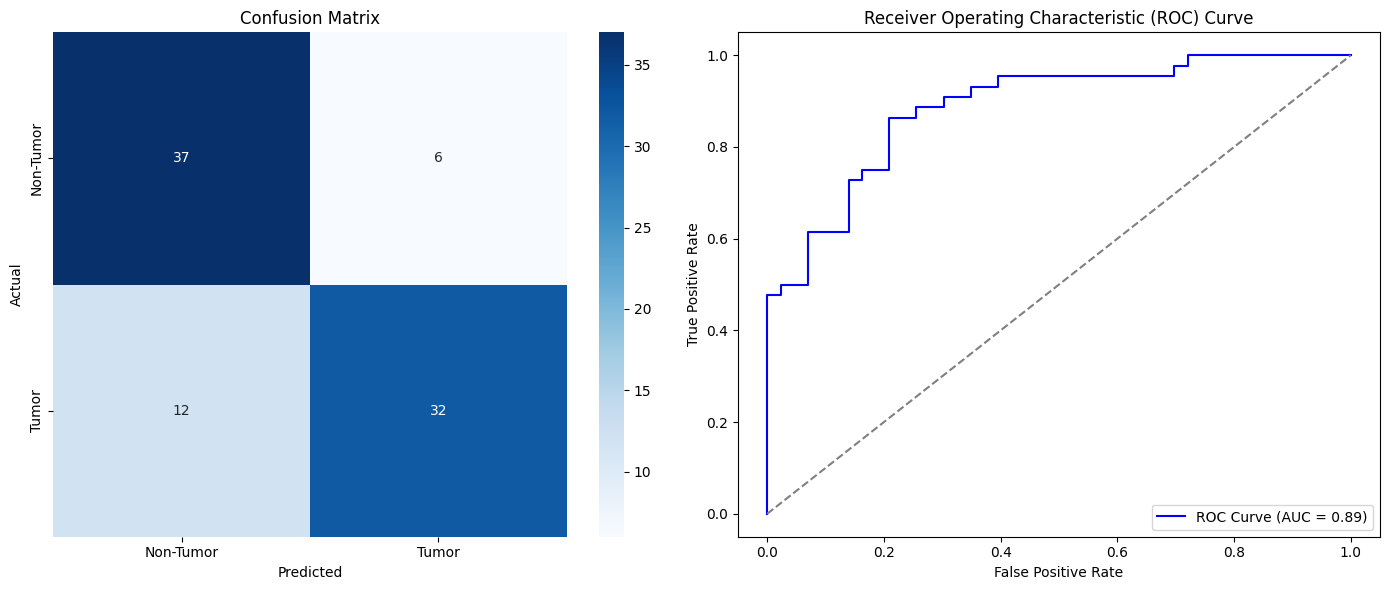

In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the final model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
vgg_model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = vgg_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],   
    verbose=1
)

# Evaluate the model using the custom test function
evaluate_model(vgg_model, X_test_rgb, y_test)
